## Performing aperture photometry with `PhotometryTool`
Now that we have sufficient local data for our list of sources from the previous two notebooks, we will be letting the `PhotometryTool` take a look at each `SourceEntry` and perform aperture photometry on the associated `DataEntry` instances in its `best_data` dictionary attribute. The result is an output photometry dictionary which contains a heap of information about each `DataEntry` used as well as the flux and flux error in the placed aperture, organised by keys of format `"sourcename_band"`.

Firstly, in case this repository is cloned and not pip installed...

In [1]:
from sys import path
import os, glob

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Navigate up to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root to sys.path
if project_root not in path:
    path.append(project_root)

Now import the necessary modules, classes and functions for this notebook

In [2]:
from quest.lib_data import DataTool
from quest.lib_photometry import PhotometryTool
from quest.lib_plot import plot_multiwl_stamps, plot_overlays, plot_photometry
import warnings
from astropy.io import fits
from astropy.wcs import FITSFixedWarning
from astropy.coordinates import SkyCoord
import astropy.units as u

(Duplicate from the first notebook) Here is an example configuration that feeds in to the initialisation and use of the classes. Some directories are created if not already existing, but they should already match the directory structure of the repository. Feel free to swap out values to test with your own data and input source lists.

In [3]:
# --- Global Configuration ---
# Working path, input source list, output database file
data_dir = '../demo/data'
src_list_file = f'{data_dir}/example_sources.lis'
# Input source list can be parsed as you wish later, but it must contain:
#   - Source (long) name... typically the J2000 coordinate in hms dms
#   - Source (short) name... this is used for display/annotation on plots
#   - Source RA and Dec... can be in whatever format you wish, but it will have to be made into a SkyCoord instance
db_save_path = f'{data_dir}/source_data_expanded.db'

# Output directories for figures and data
output_fig_dir = '../demo/figures'
output_data_dir = '../demo/output'
if not os.path.exists(output_fig_dir):
    os.mkdir(output_fig_dir)
if not os.path.exists(output_data_dir):
    os.mkdir(output_data_dir)

# Optional to section off your data into directories in some fashion (e.g. wavelength domain).
# These must exist in the working path (e.g. `./demo/data`, creating them if not).
data_sub_dirs = [f'{data_dir}/Optical', f'{data_dir}/IR', f'{data_dir}/Radio']
for search_dir in data_sub_dirs:
    if not os.path.exists(search_dir):
        os.mkdir(search_dir)

# You can define the **PHOTOMETRY** search paths here.
# Searches are made at the level of the defined paths below recursively (e.g. /my/path/**/*.fits)
data_dir_list = [f'{data_dir}/Optical', f'{data_dir}/IR']
# Similar for the **CONTOUR** search paths here, which we use the radio for (only tested with radio currently)
data_dir_radio = [f'{data_dir}/Radio']

# You can define the paths to ignore when searching here
# (i.e. if a searched path CONTAINS any of the strings in the ignore_paths list).
ignore_paths = ['dud_cutouts', f'{data_dir}/IR/unWISE', f'{data_dir}/IR/2MASS', f'{data_dir}/Radio/TGSS']

# Filter out certain warnings
warnings.filterwarnings('ignore', category=FITSFixedWarning)
warnings.filterwarnings('ignore', category=fits.verify.VerifyWarning)

Time to load up one of our saved `DataTool` states! This time we are initialising from the checkpoint we saved in the second notebook, with the expanded list of saved images. We don't need to add our sources again (but could add new ones at any point!) and we don't need to scan the local directories since we aren't retrieving any more data this time around.

In [4]:
##### Main Workflow #####

# 1. Initialize or load the data database
try:
    db = DataTool()
    db.load_from_file(filepath=db_save_path)
except (FileNotFoundError, EOFError):
    print("No existing database found or file is empty, initializing a new one.")
    db = DataTool(search_directories=data_dir_list)
    db.set_ignored_filepaths(ignore_paths=ignore_paths)

Database loaded from ../demo/data/source_data_expanded.db. Contains 2 sources and 20 checked images.


Before we jump into performing some photometry, we'll try out a function of the `DataTool` that attempts to automatically determine the weighted-average `SkyCoord` across the different bands of the most likely source segment (within some separation threshold) corresponding to the input RA and Dec.

We'll save this new state of the `DataTool` to express that we've updated the coordinates of the sources programmatically.

In [5]:
# 4. Refine host coordinates
db.find_best_host_coordinates(max_separation=2*u.arcsec, debug=False)

# 5. Save the updated database
db.save_to_file(f'{data_dir}/source_data_repositioned.db')

Finding best host coordinates...
[INFO]	No host found for TN J0924-2201, using radio coordinates.
[INFO]	../demo/data/IR/VISTA/23h18m18.35s-31d13m46.34s_VIKING_Ks_180.0arcsec_cutout.fits: Closest source to 23h18m18.3504s -31d13m46.3440s is 23h18m18.3539s -31d13m46.2904s
with separation 0.053 arcsec.
[INFO]	../demo/data/Optical/DECaLS/23h18m18.35s-31d13m46.34s_z_180.0arcsec_cutout.fits: Closest source to 23h18m18.3504s -31d13m46.3440s is 23h18m18.3692s -31d13m46.4899s
with separation 0.282 arcsec.
[INFO]	../demo/data/IR/VISTA/23h18m18.35s-31d13m46.34s_VIKING_Y_180.0arcsec_cutout.fits: Closest source to 23h18m18.3504s -31d13m46.3440s is 23h18m18.3561s -31d13m46.3709s
with separation 0.074 arcsec.
[INFO]	../demo/data/IR/VISTA/23h18m18.35s-31d13m46.34s_VIKING_H_180.0arcsec_cutout.fits: Closest source to 23h18m18.3504s -31d13m46.3440s is 23h18m18.3537s -31d13m46.4588s
with separation 0.131 arcsec.
[INFO]	../demo/data/IR/VISTA/23h18m18.35s-31d13m46.34s_VIKING_J_180.0arcsec_cutout.fits: Close

If you choose to enable the debug option above, then some additional figures will be produced which can be inspected and evaluated manually. If you decide the automatic coordinate refinement is not ideal, you can always overwrite the coordinates in the appropriate `SourceEntry` attribute, e.g. see below.

In [6]:
# 5.1 Any manual coordinate re-definitions
for source in db.sources:
    match source.short_label:
        case 'J0924':
            # Example for host galaxy overwrite goes here: source.host_coord = SkyCoord(...)
            pass

db.save_to_file(f'{data_dir}/source_data_repositioned.db')

Database saved to ../demo/data/source_data_repositioned.db.


Now that we've optimised where we will be placing our apertures, we can perform the aperture photometry! This next cell steps through a few things per `SourceEntry`. First, we initialise the `PhotometryTool` with the `SourceEntry` and point it to where we have our radio data (optional) for overlaying later. Then we perform the photometry with a given:
- aperture diameter
- maximum distance for placing random apertures in order to estimate the statistical aperture uncertainty
- option to keep apertures that sample negative fluxes at the target position
- threshold to exclude random-placed aperture fluxes (in case you don't want random apertures sitting over a bright source to bias your statistical uncertainty)
- debug option for showing the random aperture placement and exclusions on each image

Next we can plot useful figures and print the flux and flux errors per wavelength in a few in-built formats. We won't explain these in detail, but encourage you to explore the functions yourself.
- plot the SED from the aperture photometry
- plot stamps around the aperture for each `DataEntry` used
- plot stacked optical and IR data with optional overlaying of radio contours
- print the photometry results (here we generate a $\LaTeX$ table to be easily copied)

--- Performing photometry for TN J0924-2201 ---
------------------------------


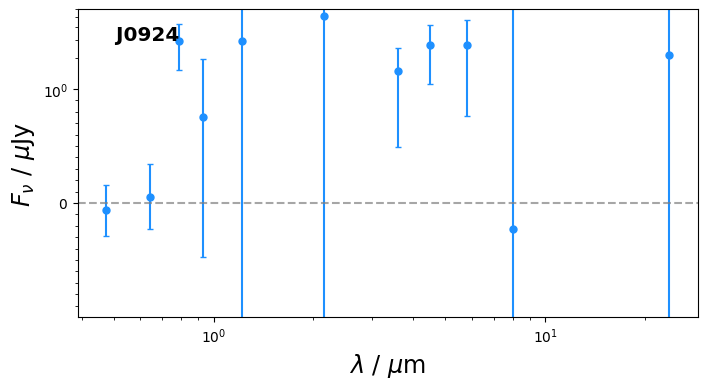

Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]


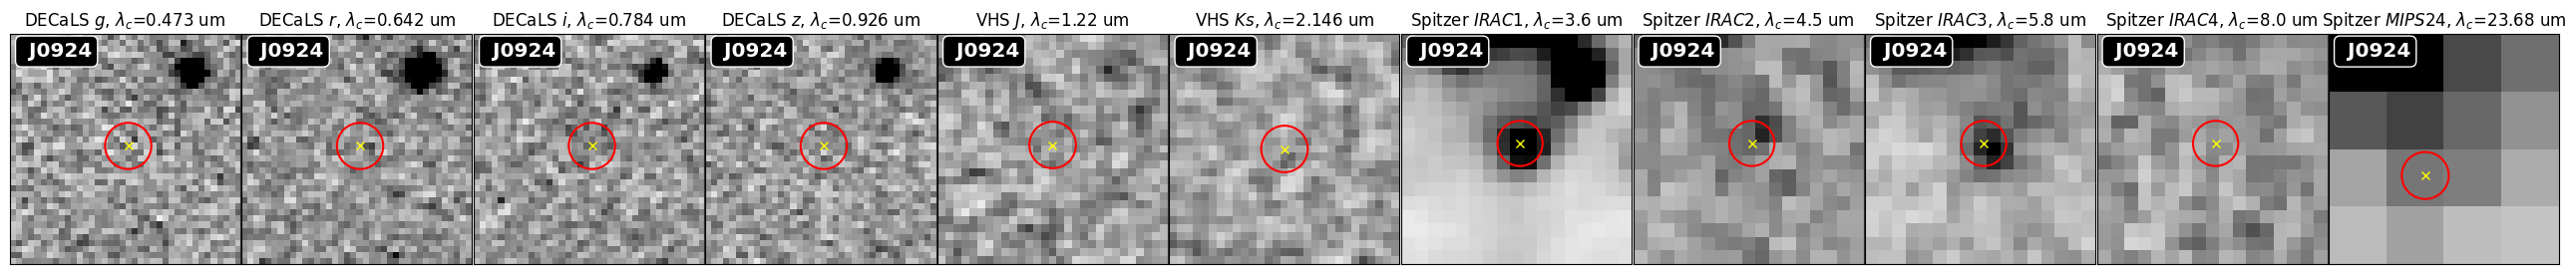

--- Generating overlay plots for TN J0924-2201 ---


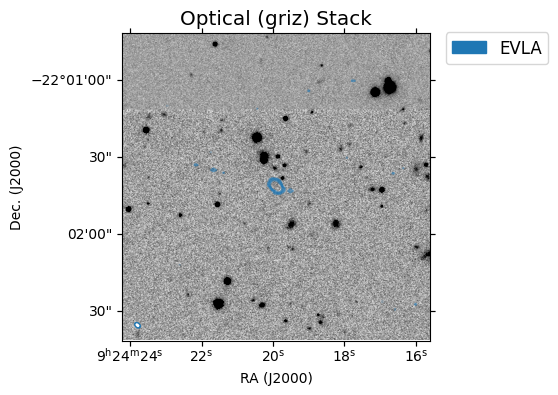

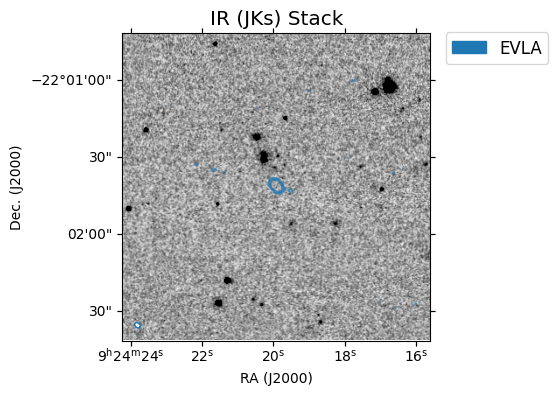

------------------------------
Source & $g$ & $r$ & $i$ & $z$ & $J$ & $Ks$ & $IRAC1$ & $IRAC2$ & $IRAC3$ & $IRAC4$ & $MIPS24$ \\
& [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] \\
 J0924 & $-0.06\pm0.22$ & $0.06\pm0.28$ & $2.91\pm1.39$ & $0.75\pm1.22$ & $2.92\pm4.18$ & $5.11\pm8.94$ & $1.50\pm1.01$ & $2.67\pm1.56$ & $2.71\pm1.95$ & $-0.23\pm9.54$ & $2.12\pm4.85$\\

--- Performing photometry for VIK J2318−3113 ---
------------------------------


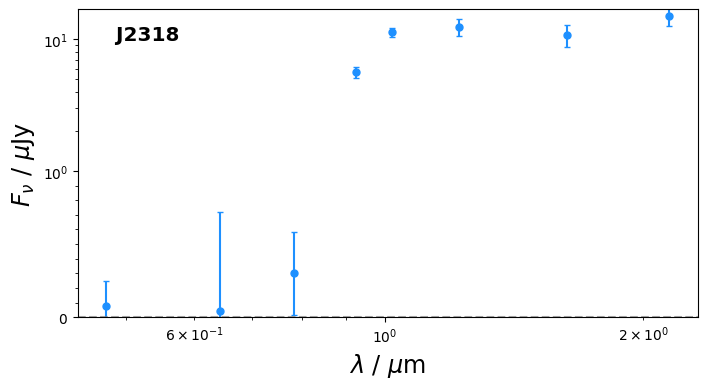

Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]


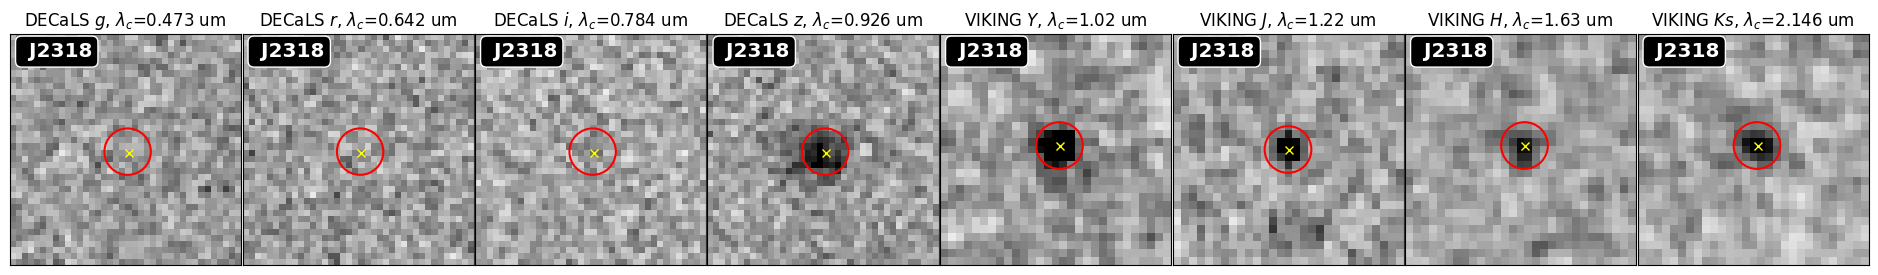

--- Generating overlay plots for VIK J2318−3113 ---


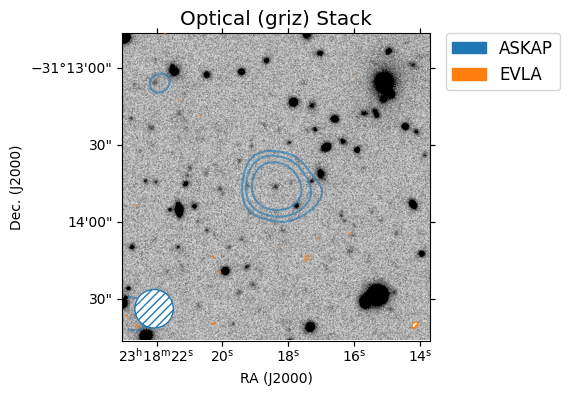

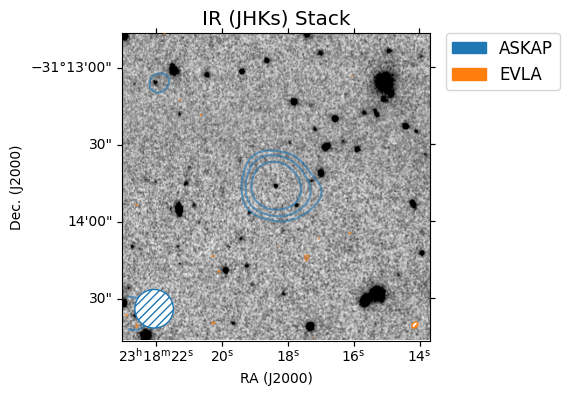

------------------------------
Source & $g$ & $r$ & $i$ & $z$ & $Y$ & $J$ & $H$ & $Ks$ \\
& [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] & [\textmu{}Jy] \\
 J2318 & $0.08\pm0.17$ & $0.04\pm0.68$ & $0.30\pm0.28$ & $5.65\pm0.53$ & $11.35\pm0.90$ & $12.52\pm1.86$ & $10.78\pm2.07$ & $14.96\pm2.41$\\



In [7]:
# 6. Perform analysis and generate products
aperture_diameter = 2 * u.arcsec
all_phot = []
for source in db.sources:
    phot_tool = PhotometryTool(source, data_dir_radio, output_fig_dir=output_fig_dir)
    phot_tool.perform_photometry(ap_diameter=aperture_diameter, ap_max_dist=60*u.arcsec, keep_negative=True,
                                 rand_aper_flux_sigma_clip=10, debug=False)
    all_phot.append(phot_tool.photometry_data)
    
    # Generate plots and tables
    plot_photometry(phot_tool, save_path=output_fig_dir, ignore_negative=False)
    plot_multiwl_stamps(phot_tool, cutout_size=10*u.arcsec, save_path=output_fig_dir, sigma_clip_norm=5,
                                  ignore_negative=False, ap_diameter=aperture_diameter)
    plot_overlays(phot_tool, save_path=output_fig_dir, stamp_radius=60*u.arcsec, sigma_clip_norm=5,
                  add_beam=True, ignore_negative=True, data_dir_radio=data_dir_radio, contour_step=2)
    phot_tool.print_photometry(out_type='latex')

As a fun fact, the photometry for the high-redshift radio galaxy TN J0924-2201 ($z\approx5.2$), although quite poor with plenty of non-detections overall, does reveal some characteristic features of its SED:
- Lyman-$\alpha$ contaminated $i$-band flux
- Detection in $Spitzer$ IRAC bands longward of the Balmer/D4000 $\AA$ break

Here's also an example of experimenting with some of the plotting argument options and using a smaller aperture.

--- Performing photometry for TN J0924-2201 ---
------------------------------


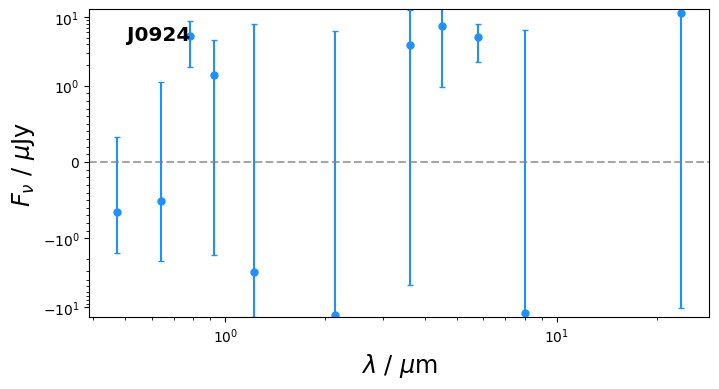

Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]


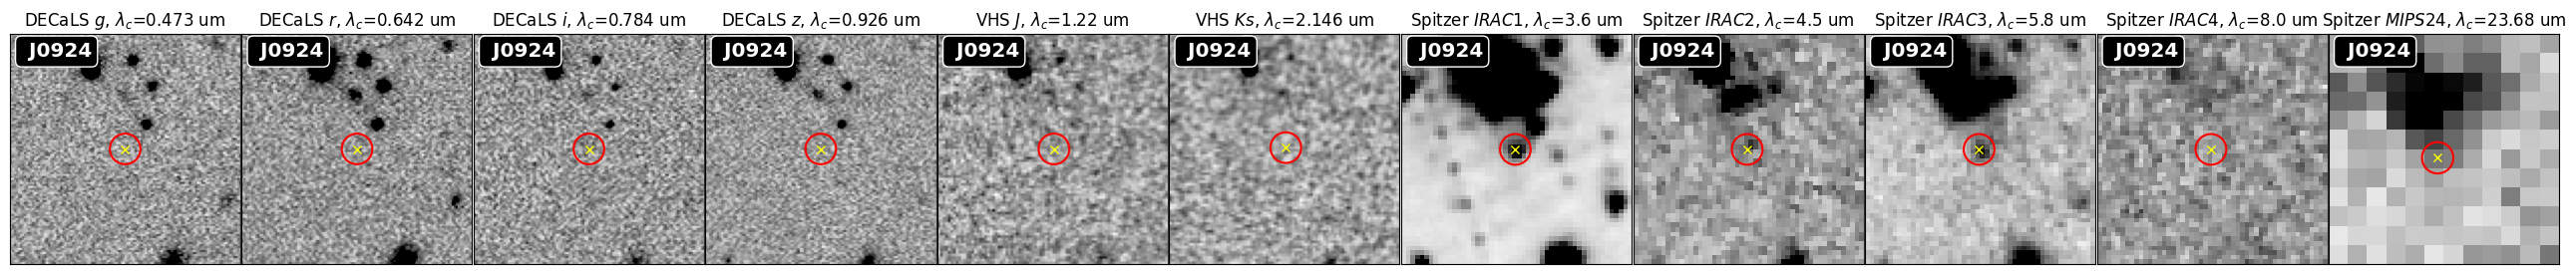

--- Generating overlay plots for TN J0924-2201 ---


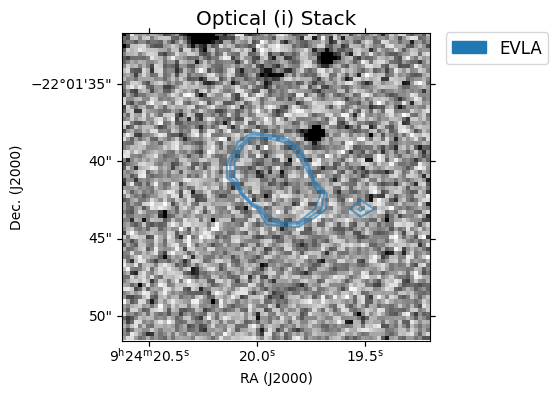

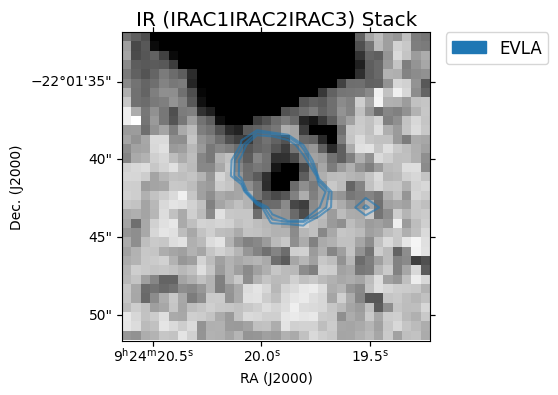

------------------------------


In [8]:
# Example alternative plots with fine-control
aperture_diameter = 4*u.arcsec  # Bigger aperture

source = db.sources[0]
phot_tool = PhotometryTool(source, data_dir_radio, output_fig_dir=output_fig_dir)
phot_tool.perform_photometry(ap_diameter=aperture_diameter, ap_max_dist=60*u.arcsec, keep_negative=True,
                                rand_aper_flux_sigma_clip=10, debug=False)

# Generate plots and tables
plot_photometry(phot_tool, save_path=None, ignore_negative=True)
plot_multiwl_stamps(phot_tool, cutout_size=30*u.arcsec, save_path=None, sigma_clip_norm=5,
                              ignore_negative=True, ap_diameter=aperture_diameter)
plot_overlays(phot_tool, save_path=None, stamp_radius=10*u.arcsec,
              optical_bands=['i'], ir_bands=['IRAC1','IRAC2','IRAC3'],
              ignore_negative=True, data_dir_radio=data_dir_radio, sigma_clip_norm=3, add_beam=False)

### Aperture photometry is done!
But there's still a few ways to interact with some of the functionality introduced in this notebook. Here are a couple.

1. Alternate printing of photometry, including directing towards an output file.

In [9]:
PhotometryTool.print_all_photometry(all_phot, out_type='beagle', out_file=f'{output_data_dir}/phot')
PhotometryTool.print_all_photometry(all_phot, out_type='str')

Source,              0.473 um,              0.642 um,              0.784 um,              0.926 um,               1.02 um,               1.22 um,               1.63 um,              2.146 um,                3.6 um,                4.5 um,                5.8 um,                8.0 um,              23.68 um
 J0924, -6.355e-08+-2.226e-07,  5.660e-08+-2.849e-07,  2.911e-06+-1.389e-06,  7.544e-07+-1.224e-06,                    --,  2.916e-06+-4.182e-06,                    --,  5.108e-06+-8.941e-06,  1.501e-06+-1.011e-06,  2.668e-06+-1.558e-06,  2.712e-06+-1.952e-06, -2.306e-07+-9.537e-06,  2.122e-06+-4.848e-06
 J2318,  7.586e-08+-1.692e-07,  3.933e-08+-6.802e-07,  3.016e-07+-2.836e-07,  5.653e-06+-5.305e-07,  1.135e-05+-9.019e-07,  1.252e-05+-1.856e-06,  1.078e-05+-2.072e-06,  1.496e-05+-2.414e-06,                    --,                    --,                    --,                    --,                    --



2. Comparing the original input coordinates to the repositioned coordinates.

In [10]:
print("RADIO\t\t\t\tAPERTURE/CANDIDATE HOST")
for source in db.sources:
    print(f"{source.radio_coord.to_string(style='hmsdms', precision=3)}", end='')
    print(f"\t{source.host_coord.to_string(style='hmsdms', precision=3)}")

RADIO				APERTURE/CANDIDATE HOST
09h24m19.920s -22d01m41.498s	09h24m19.920s -22d01m41.498s
23h18m18.350s -31d13m46.344s	23h18m18.353s -31d13m46.305s
